In [23]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima

# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5

# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

# Configuración warnings
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

In [24]:
lugar_nacimiento=pd.read_csv('t674mun_171899LA CELLERA DE TER.csv', sep=';')

In [25]:
lugar_nacimiento=lugar_nacimiento.rename(columns={'Unnamed: 0': 'Año'})

In [26]:
lugar_nacimiento.columns

Index(['Año', 'Catalunya', 'Mateixa comarca', 'Altra comarca',
       'Resta d'Espanya', 'Estranger', 'Total'],
      dtype='object')

In [27]:
lugar_nacimiento_santfeliu=lugar_nacimiento.sort_values(by='Año', ascending=True)
lugar_nacimiento_santfeliu

,Año,Catalunya,Mateixa comarca,Altra comarca,Resta d'Espanya,Estranger,Total
22,2000,1745,1295,450,202,72,2019
21,2001,1772,1306,466,199,84,2055
20,2002,1768,1302,466,203,91,2062
19,2003,1755,1286,469,201,108,2064
18,2004,1739,1257,482,189,110,2038
17,2005,1721,1254,467,190,153,2064
16,2006,1709,1246,463,185,202,2096
15,2007,1712,1250,462,186,226,2124
14,2008,1721,1253,468,181,260,2162
13,2009,1728,1252,476,178,280,2186


In [28]:
serie_extranjeros_santfeliu = lugar_nacimiento_santfeliu[['Año', 'Estranger']]
serie_extranjeros_santfeliu= lugar_nacimiento_santfeliu.set_index('Año')
serie_extranjeros_santfeliu.index = pd.to_datetime(serie_extranjeros_santfeliu.index, format='%Y')
serie_extranjeros_santfeliu = serie_extranjeros_santfeliu['Estranger']

In [29]:
print(f'Número de filas con missing values: {lugar_nacimiento.isnull().any(axis=1).mean()}')

Número de filas con missing values: 0.0


Fechas train : 2000-01-01 00:00:00 --- 2015-01-01 00:00:00  (n=16)
Fechas test  : 2016-01-01 00:00:00 --- 2022-01-01 00:00:00  (n=7)


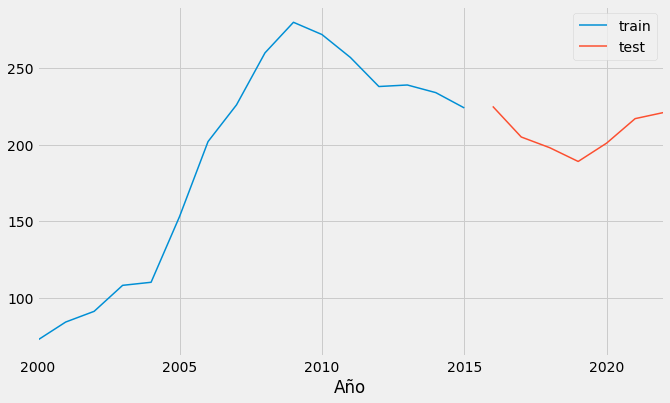

In [30]:
# Separación datos train-test
# ==============================================================================
steps = 7 #se utilizan los últimos 7 años como conjunto test para evaluar la capacidad del modelo
datos_train = serie_extranjeros_santfeliu[:-steps]
datos_test  = serie_extranjeros_santfeliu[-steps:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

fig, ax = plt.subplots(figsize=(10, 6))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
ax.legend();

### ForecasterAutoreg

Se crea y entrena un modelo ForecasterAutoreg a partir de un regresor RandomForestRegressor y una ventana temporal de 7 lags. Esto último significa que, el modelo, utiliza como predictores los 7 años anteriores.

In [31]:
#datos_test.index = pd.to_datetime(datos_test.index, format='%Y-%m-%d')
#datos_train.index = pd.to_datetime(datos_train.index, format='%Y-%m-%d')

In [32]:
datos_test

Año
2016-01-01    225
2017-01-01    205
2018-01-01    198
2019-01-01    189
2020-01-01    201
2021-01-01    217
2022-01-01    221
Name: Estranger, dtype: int64

In [33]:
freq = pd.infer_freq(datos_train.index)
datos_train.index = pd.date_range(start=datos_train.index[0], periods=len(datos_train), freq=freq)

In [34]:
freq = pd.infer_freq(datos_test.index)
datos_test.index = pd.date_range(start=datos_test.index[0], periods=len(datos_test), freq=freq)

In [35]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 7
             )

forecaster.fit(y=datos_train)
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6 7] 
Transformer for y: None 
Transformer for exog: None 
Window size: 7 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2000-01-01 00:00:00'), Timestamp('2015-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: AS-JAN 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-04-13 00:12:32 
Last fit date: 2023-04-13 00:12:32 
Skforecast version: 0.7.0 
Python version: 3.10.5 
Forecaster id: None 

### Predicciones

Una vez entrenado el modelo, se predicen los datos de test (5 años a futuro).

In [36]:
steps = 7
predicciones = forecaster.predict(steps=steps)
predicciones.head(7)

2016-01-01    232.32
2017-01-01    233.24
2018-01-01    233.78
2019-01-01    234.50
2020-01-01    233.80
2021-01-01    233.54
2022-01-01    233.84
Freq: AS-JAN, Name: pred, dtype: float64

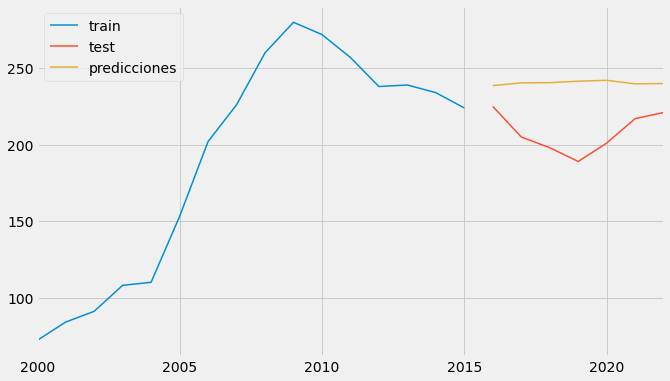

In [46]:
# Gráfico
fig, ax = plt.subplots(figsize=(10, 6))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

fig.savefig('train_testprueba_santfeliu.png')

In [47]:
freq = pd.infer_freq(serie_extranjeros_santfeliu.index)
serie_extranjeros_santfeliu.index = pd.date_range(start=serie_extranjeros_santfeliu.index[0], periods=len(serie_extranjeros_santfeliu), freq=freq)

In [48]:
regressor = RandomForestRegressor(max_depth=3, n_estimators=100, random_state=123)
forecaster_f = ForecasterAutoreg(
                regressor = regressor,
                lags      = 5
             )

forecaster_f.fit(y=serie_extranjeros_santfeliu)

In [49]:
from datetime import datetime, timedelta
# Definir la fecha de inicio y el número de pasos
fecha_inicio = serie_extranjeros_santfeliu.index[-1] + timedelta(days=1)
pasos = 5 #5 años en dias

# Crear un objeto de índice de tiempo para los pasos de predicción
indice_tiempo = pd.date_range(start=fecha_inicio, periods=pasos, freq='Y')

# Hacer las predicciones
predicciones_f = forecaster_f.predict(steps=pasos)

In [50]:
predicciones_f

2023-01-01    223.415169
2024-01-01    226.170026
2025-01-01    242.610939
2026-01-01    242.894367
2027-01-01    242.964645
Freq: AS-JAN, Name: pred, dtype: float64

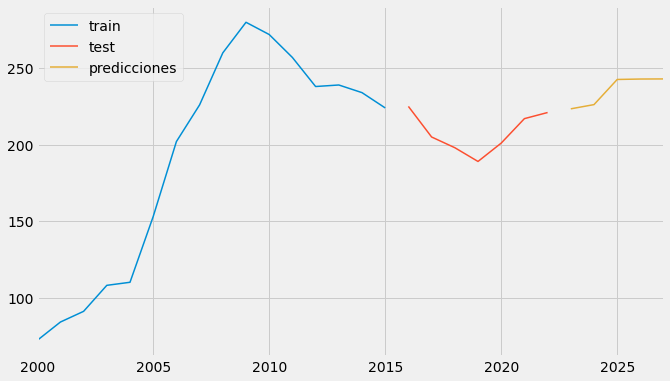

In [51]:
# Gráfico
fig, ax = plt.subplots(figsize=(10, 6))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predicciones_f.plot(ax=ax, label='predicciones')
ax.legend();

fig.savefig('prediccion_santfeliu.png')

### Error de las predicciones en el conjunto de test

Se cuantifica el error que comete el modelo en sus predicciones. En este caso, se emplea como métrica el mean squared error (mse).

In [38]:
# Error test

error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predicciones
            )

print(f"Error de test (mse): {error_mse}")

Error de test (mse): 816.5450857142858


### Ajuste de hiperparámetros (tuning)

El ForecasterAutoreg entrenado ha utilizado una ventana temporal de 6 lags y un modelo Random Forest con los hiperparámetros por defecto. Sin embargo, no hay ninguna razón por la que estos valores sean los más adecuados. Para identificar la mejor combinación de lags e hiperparámetros, la librería Skforecast dispone de la función grid_search_forecaster con la que comparar los resultados obtenidos con cada configuración del modelo.

In [39]:
# Grid search de hiperparámetros

steps = 7
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 7 # Este valor será remplazado en el grid search
             )

# Lags utilizados como predictores
lags_grid = [5,10]

# Hiperparámetros del regresor
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 7]}

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos_train,
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = 15,
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
                  )

Number of models compared: 12.


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:06<00:00,  3.24s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 191.15827599999983



In [40]:
# Resultados Grid Search

resultados_grid

,lags,params,mean_squared_error,max_depth,n_estimators
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 500}",191.158276,3,500
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 500}",191.158276,5,500
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 7, 'n_estimators': 500}",191.158276,7,500
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 100}",200.505600,3,100
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",200.505600,5,100
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 7, 'n_estimators': 100}",200.505600,7,100
2,"[1, 2, 3, 4, 5]","{'max_depth': 5, 'n_estimators': 100}",200.788900,5,100
4,"[1, 2, 3, 4, 5]","{'max_depth': 7, 'n_estimators': 100}",200.788900,7,100
3,"[1, 2, 3, 4, 5]","{'max_depth': 5, 'n_estimators': 500}",221.950404,5,500
5,"[1, 2, 3, 4, 5]","{'max_depth': 7, 'n_estimators': 500}",221.950404,7,500


Los mejores resultados se obtienen si se utiliza una ventana temporal de 5 lags y una configuración de Random Forest {'max_depth': 3, 'n_estimators': 100}.

### Modelo final

Finalmente, se entrena de nuevo un ForecasterAutoreg con la configuración óptima encontrada mediante validación. Este paso no es necesario si se indica return_best = True en la función grid_search_forecaster.

In [41]:
# Crear y entrenar forecaster con mejores hiperparámetros

regressor = RandomForestRegressor(max_depth=3, n_estimators=100, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 5
             )

forecaster.fit(y=datos_train)

In [42]:
# Predicciones
predicciones = forecaster.predict(steps=steps)

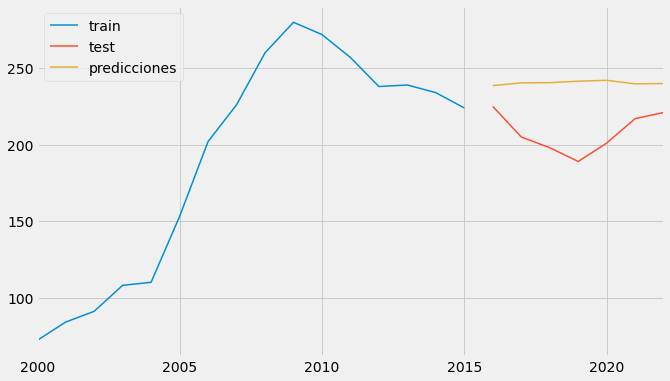

In [43]:
# Gráfico
fig, ax = plt.subplots(figsize=(10, 6))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

### Error del Test

In [44]:
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predicciones
            )

print(f"Error de test (mse) {error_mse}")

Error de test (mse) 1223.2033422301604
